In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

WALL_CELL_CONTENT = 1
FREE_CELL_CONTENT = 0
SIZE_LABYRINTH = 40

# IA - Labyrinth

In [2]:
def generate_labyrinth(width, height, wall_ratio=0.3):
    """ Randomly generates the labyrinth matrix, the values are:
    0 if the cell is free
    1 if there is a wall
    :param width int: width of the matrix
    :param height int: height of the matrix
    :wall_ratio float: chance for a cell to be a wall
    :return: tuple composed of:
    <matrix>: numpy 2d array
    <start_cell>: tuple of i, j indices for the start cell
    <end_cell>: tuple of i, j indices for the end cell
    """
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

def load_grid(filename):
    grid = np.load(filename)
    start_cell = (0,0)
    h = grid.shape[0]
    w = grid.shape[1]
    end_cell = (h - 1, w - 1)
    
    return grid, start_cell, end_cell

In [3]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    """ Display the labyrinth matrix and possibly the solution with matplotlib.
    Free cell will be in light gray.
    Wall cells will be in dark gray.
    Start and end cells will be in dark blue.
    Path cells (start, end excluded) will be in light blue.
    :param grid np.array: labyrinth matrix
    :param start_cell: tuple of i, j indices for the start cell
    :param end_cell: tuple of i, j indices for the end cell
    :param solution: list of successive tuple i, j indices who forms the path
    """
    grid = np.array(grid, copy=True)
    START = 0
    END = 0
    PATH = 2
    WALL_CELL = 16
    FREE_CELL = 19
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    grid[start_cell] = START
    grid[end_cell] = END
    if solution:
        solution = solution[1:-1]
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    plt.matshow(grid, cmap="tab20c")

In [4]:
# grid, start_cell, end_cell = generate_labyrinth(SIZE_LABYRINTH, SIZE_LABYRINTH)
grid, start_cell, end_cell = load_grid("grids/grid40.npy")

No solution has been found


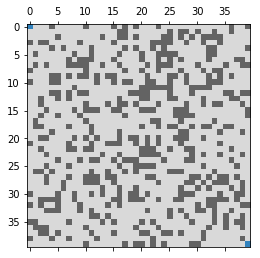

In [5]:
display_labyrinth(grid, start_cell, end_cell)

# Imports
        

In [6]:
from deap import base
from deap import creator
from deap import tools 
from deap import algorithms
import random
from enum import Enum
from collections import namedtuple

# Data Structure

In [7]:
NB_DIRECTIONS = grid.shape[0] * grid.shape[1]
CHROMOSOM_LENGTH = NB_DIRECTIONS
    
class Direction(Enum):
    """
    enum for every direction possible
    """
    TOP = 0
    RIGHT = 1
    BOTTOM = 2
    LEFT = 3


# Structure and algorithm functions

In [8]:
def _parse_code(code):
    """
    transform an int into a direction
    """
    return Direction(int(code))


def _decode(individual):
    """
    transform the int of the chromosom to a list of direction
    """
    return list(map(lambda val: Direction(val), individual))


def individual_to_str(individual):
    """
    transform a an individual in a string
    """
    return " ".join(d.name[0] for d in _decode(individual))


def compute_chromosome(individual, labyrinth, start, end):
    """
    transform an individual in a list of coordinates (path)
    """
    
    directions = _decode(individual) 
    x, y = start[0], start[1]
    result = [(x,y)]
    
    for direction in directions:
        # add the next coordinates in the path
        new_x, new_y = get_new_xy_with_direction(x, y, direction)
        
        new_coordinates = (new_x, new_y)
        
        # if going out of the grid or against a wall, do not move
        if new_x >= 0 and new_y >= 0 \
            and new_x < grid.shape[0] and new_y < grid.shape[1] \
            and grid[new_coordinates] == FREE_CELL_CONTENT:
            result.append(new_coordinates)
            x = new_x
            y = new_y
    
    return result


def fix_chromosom(individual, grid, start_cell, end_cell):
    """
    fix a chromosom by finding place where he went already or go against a wall
    """
    PROB_RANDOM_PATH = 0.3
    
    directions = _decode(individual) 
    x, y = start_cell[0], start_cell[1]
    path = [(x,y)]
    
    for i, direction in enumerate(directions):
        # add the next coordinates in the path
        new_x, new_y = get_new_xy_with_direction(x, y, direction)
        
        new_coordinates = (new_x, new_y)

        if new_x >= 0 and new_y >= 0 \
            and new_x < grid.shape[0] and new_y < grid.shape[1] \
            and grid[new_coordinates] == FREE_CELL_CONTENT \
            and not new_coordinates in path:
            
            path.append(new_coordinates)
            x, y = new_x, new_y
        else :
            # find a new direction random or closest to the target
            if random.random() < PROB_RANDOM_PATH:
                individual[i] = random.randint(0, len(Direction) - 1)
            else:
                individual[i] = find_better_path(path[-1], end_cell) # always go the same places, not really good
            
            
            new_x, new_y = get_new_xy_with_direction(x, y, Direction(individual[i]))
            new_coordinates = (new_x, new_y)
            
            # Check the new direction is doable
            if new_x >= 0 and new_y >= 0 \
                and new_x < grid.shape[0] and new_y < grid.shape[1] \
                and grid[new_coordinates] == FREE_CELL_CONTENT \
                and not new_coordinates in path:
                
                path.append(new_coordinates)
                x, y  = new_x, new_y
                
        # if at the end cut the chromosom
        if (x,y) == end_cell:
            individual = individual[0:i]
            return

def change_useless_move(individual):
    """
    change useless move
    was a first optimisation, not used anymore but kept for history
    """
    directions = _decode(individual)
    
    for i, d in enumerate(directions):
        if i+1 < len(directions) and ( \
            d == Direction.TOP and directions[i+1] == Direction.BOTTOM \
            or d == Direction.BOTTOM and directions[i+1] == Direction.TOP \
            or d == Direction.LEFT and directions[i+1] == Direction.RIGHT \
            or d == Direction.RIGHT and directions[i+1] == Direction.LEFT):
            
            individual[i] = random.randint(0, len(Direction)-1)
            
            

def get_new_xy_with_direction(x, y, direction):
    """
    get the new x and y from a direction
    """
    new_x = x
    new_y = y
    
    if direction == Direction.TOP:
        new_x -= 1
    elif direction == Direction.RIGHT:
        new_y += 1
    elif direction == Direction.BOTTOM:
        new_x += 1
    elif direction == Direction.LEFT:
        new_y -= 1
        
    return new_x, new_y


def find_better_path(position, target):
    """
    Try to get the best direction for a point
    """
    if difference_x(position, target) > difference_y(position, target):
        if position[0] < target[0]:
            return Direction.BOTTOM
        else :
            return Direction.TOP
    else:
        if position[1] < target[1]:
            return Direction.RIGHT
        else:
            return Direction.LEFT

        
def difference_x(p1, p2):
    """
    get the difference of the x of the vector
    """
    return abs(p1[0]-p2[0])


def difference_y(p1, p2):
    """
    get the difference of the y of the vector
    """
    return abs(p1[1]-p2[1])


def manhattan(p1, p2):
    """
    manhattan distance between two points
    """
    return difference_x(p1, p2)+difference_y(p1, p2)

# Fitness related function

In [9]:
def fitness(individual, grid, start_cell, end_cell, chromosome_length):
    """
    fitness function, will calculate a fitness with the manhattan distance of the point, the length of the path and a malus if it doesn't reach the end
    """
    FACTOR = 20
    
    path = compute_chromosome(individual, grid, start_cell, end_cell)
    
    return (manhattan(end_cell, path[-1])*FACTOR + len(individual),)


def evaluate_population(population, grid, start_cell, end_cell):
    """
    find the fitness of every individual
    """
    fitnesses = [toolbox.fitness(ind, grid, start_cell, end_cell, CHROMOSOM_LENGTH) for ind in population]
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit


# Deap

In [10]:
toolbox = base.Toolbox()

In [11]:
toolbox.register("fitness", fitness)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.3)
toolbox.register("select", tools.selRoulette)

toolbox.register("init_gene", random.randint, 0, 3)
toolbox.register("init_individual", tools.initRepeat, creator.Individual, toolbox.init_gene, CHROMOSOM_LENGTH)
toolbox.register("init_population", tools.initRepeat, list, toolbox.init_individual)

## Solve

In [12]:
def find_winners(population, grid, start_cell, end_cell):
    """
    find all the winners of a population
    not useful
    """
    winners = []
    
    for individual in population:
        path = compute_chromosome(individual, grid, start_cell, end_cell)
        if path[-1] == end_cell:
            winners.append(individual)
    
    return winners


def find_best(population):
    """
    find the best individual in a population,
    individual need a fitness attribute
    """
    fitnesses = [ind.fitness.values[0] for ind in population]
    min_fit = min(fitnesses)
    
    return population[fitnesses.index(min_fit)]        
            
def solve_labyrinth(grid, start_cell, end_cell, max_time_s):
    """
    function of the genetic algorithm to find the solution
    """
    N_POPULATION = 50
    CROSSOVER_PROBA = 0.1
    MUTATE_PROBA = 0.6
    
    start_time = inter_time = time.time()
    population = toolbox.init_population(n = N_POPULATION)

    evaluate_population(population, grid, start_cell, end_cell)
    solution = None
    
    # do not need a stop condition other than time because we always keep the best
    while inter_time - start_time < max_time_s:
        # selection
        children = toolbox.select(population, len(population))
        children = list(map(toolbox.clone, children))
        
        # spawning new child
        for i in range(0, len(population) - len(children)):
            children.append(toolbox.init_individual())
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(children[::2], children[1::2]):
            if random.random() < CROSSOVER_PROBA:
                toolbox.mate(child1, child2) 
        
        # mutation
        for mutant in children:
            # add a new component
            if random.random() < MUTATE_PROBA:
                toolbox.mutate(mutant)
                
        # fixing chromosome
        for child in children:
            fix_chromosom(child, grid, start_cell, end_cell)

        evaluate_population(children, grid, start_cell, end_cell)
        population = children

        # Search for the solution
        best = find_best(children)
        
        if not solution or best.fitness.values[0] < solution.fitness.values[0]:
            solution = best

        inter_time = time.time()
    
    return compute_chromosome(solution, grid, start_cell, end_cell)


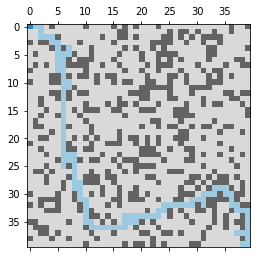

In [13]:
solution = solve_labyrinth(grid, start_cell, end_cell, 60)    
display_labyrinth(grid, start_cell, end_cell, solution)


# Conclusion

## Fitness

La fonction de fitness prend en compte la longueur du chemin parcouru et la distance de manhattan du dernier point du chemin et de la cible.

La distance de manhattan est considéré comme plus important car la taille du chemin peut varier si l'individu bloque dans un mur.

## Hyperparamètres

### Mutation

probabilité de chaque élément d'un chromosome de muté : 0.3

porbabilité d'un individu de muter : 0.8

J'ai choisi une probabilité de mutation très élevé car mes chemins sont tous très mauvais au début et ils ont besoin de de beaucoup changer au fil du temps. De plus je garde toujours le meilleur chemin sans transformation. Ce qui me permet de ne pas muter le meilleur

### Sélection

J'ai choisi la roulette pour supprimer des éléments au hasard au cas ou un mauvais se transforme en quelque chose de très bien avec une mutation ou un crossover

### Crossover

probabilité : 0.1

Il n'y a pas vraiment d'intérêt à faire un crossover entre 2 chemins. Mais j'ai gardé une faible probabilité au cas ou ça donnera un bon résultat

### Population

Taille : 50

Car avec la méthode d'optimisation les individues se dirige souvent dans la bonne direction et limitant le nombre de possibilité. Je vais donc essayé d'avoir plus mutations et de crossover par individu dans le temps donné plutôt quand

## Optimisations

J'ai essayé d'optimisé les chemins en changeant la direction quand ils vont dans un mur ou un endroit où ils sont déjà allé.

Je vais choisir une direction aléatoire ou la plus proche de la cible. Ce choix est fait grâce à de l'aléatoire avec une probabilité de 30% d'être aléatoire. Cette probabilité a été choisie en faisant plusieurs essais.


# Warning

Change LABYRINTH_SIZE if grid isn't 40x40